## Question 1

[480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591, 594, 593, 599, 546, 564, 465, 377]


<BarContainer object of 20 artists>

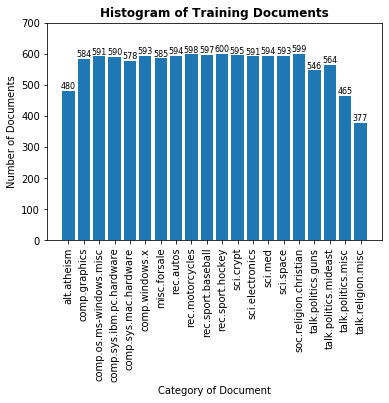

In [1]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
# import numpy as np
# np.random.seed(42)
# import random
# random.seed(42)
# categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
# 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
# train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, random_state = 42)
# test_dataset = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True, random_state = 42)
newsgroups = fetch_20newsgroups(subset = 'train')
categories = list(newsgroups.target_names)
dataVal = []
train_datas =[]
for data in categories:
    train_dataset = fetch_20newsgroups(subset='train',categories = [data])
    train_datas.append(train_dataset.data)
    dataVal.append(len(train_dataset.data))
print(dataVal)
for a,b in zip(categories,dataVal):
    plt.text(a, b+0.3, '%.0f' % b, ha='center', va= 'bottom',fontsize=8)
plt.xticks(range(20),categories,rotation = 90)
plt.ylim(0,700)
plt.xlabel('Category of Document')
plt.ylabel('Number of Documents')
plt.title('Histogram of Training Documents', fontweight='bold')
plt.bar(categories,dataVal)

## Question 2

In [2]:
import numpy as np 
np.random.seed(42) 
import random 
random.seed(42)
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

In [3]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
from nltk import pos_tag

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

analyzer = CountVectorizer().build_analyzer()

def ana_notnum(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

In [5]:
vectorizer = CountVectorizer(min_df=3, 
                             analyzer=ana_notnum, 
                             stop_words='english')

# fit_tranform train data
X_train_counts = vectorizer.fit_transform(train_dataset.data)
print("train count size ", X_train_counts.shape)

X_test_counts = vectorizer.transform(test_dataset.data)
print("test count size ", X_test_counts.shape)

train count size  (4732, 16600)
test count size  (3150, 16600)


In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit_tranform train data
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# transform test data
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [7]:
print(type(X_train_tfidf))
print(X_test_tfidf.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(3150, 16600)


## Question 3

In [8]:
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)
print(X_train_LSI.shape)

LSI_frobenius = np.sum(np.array(pow(np.asarray((X_train_tfidf - lsi.inverse_transform(X_train_LSI))),2)))
print("Squared Frobenius Norm for LSI: ", str(LSI_frobenius))

(4732, 50)
Squared Frobenius Norm for LSI:  3895.418679693327


In [9]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, init='random', random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

print(X_train_NMF.shape)
H = nmf.components_
NMF_frobenius = np.sum(pow(np.asarray(X_train_tfidf - X_train_NMF.dot(H)),2))
print("Squared Frobenius Norm for NMF: ", str(NMF_frobenius))

(4732, 50)
Squared Frobenius Norm for NMF:  3940.3425139328747


## Question 4

In [10]:
# Try to do 2-category classification with SVM
Y_train_SVM = np.zeros(train_dataset.target.shape)
Y_test_SVM = np.zeros(test_dataset.target.shape)

Y_train_SVM[train_dataset.target > 3] = 1
Y_test_SVM[test_dataset.target > 3] = 1

In [11]:
from sklearn.svm import SVC

svm_hard = SVC(C=1000, kernel='linear', random_state=42)
svm_soft = SVC(C=0.0001, kernel='linear', random_state=42)

svm_hard.fit(X_train_LSI, Y_train_SVM)
svm_soft.fit(X_train_LSI, Y_train_SVM)

Y_test_prob_hard = svm_hard.decision_function(X_test_LSI)
Y_test_label_hard = svm_hard.predict(X_test_LSI)
Y_test_prob_soft = svm_soft.decision_function(X_test_LSI)
Y_test_label_soft = svm_soft.predict(X_test_LSI)

In [12]:
Y_test_label_hard

array([0., 0., 0., ..., 1., 0., 0.])

In [13]:
from sklearn.metrics import roc_curve

fpr_hard, tpr_hard, _ = roc_curve(Y_test_SVM, Y_test_prob_hard)
fpr_soft, tpr_soft, _ = roc_curve(Y_test_SVM, Y_test_prob_soft)

AUC of hard margin 0.9954245283018869


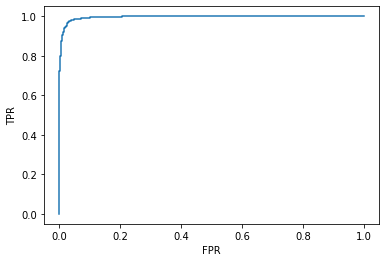

In [14]:
plt.plot(fpr_hard,tpr_hard)

plt.xlabel('FPR')
plt.ylabel('TPR')
from sklearn.metrics import auc
auc_hard = auc(fpr_hard,tpr_hard)
print('AUC of hard margin', auc_hard)

AUC of soft margin 0.9749213836477987


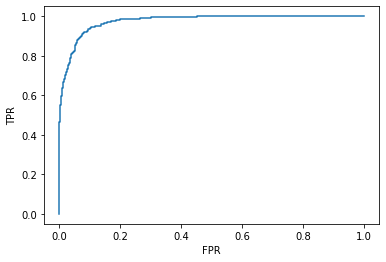

In [15]:
plt.plot(fpr_soft,tpr_soft)

plt.xlabel('FPR')
plt.ylabel('TPR')
auc_soft = auc(fpr_soft,tpr_soft)
print('AUC of soft margin', auc_soft)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Hard Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_SVM, Y_test_label_hard))
print('accuracy:', accuracy_score(Y_test_SVM, Y_test_label_hard))
print('recall:', recall_score(Y_test_SVM, Y_test_label_hard))
print('precision:', precision_score(Y_test_SVM, Y_test_label_hard))
print('F-1 score:', f1_score(Y_test_SVM, Y_test_label_hard), '\n')
print('Soft Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_SVM, Y_test_label_soft))
print('accuracy:', accuracy_score(Y_test_SVM, Y_test_label_soft))
print('recall:', recall_score(Y_test_SVM, Y_test_label_soft))
print('precision:', precision_score(Y_test_SVM, Y_test_label_soft))
print('F-1 score:', f1_score(Y_test_SVM, Y_test_label_soft))

Hard Margin Linear SVMs:
confusion_matrix:
 [[1498   62]
 [  33 1557]]
accuracy: 0.9698412698412698
recall: 0.9792452830188679
precision: 0.9617047560222359
F-1 score: 0.9703957619196011 

Soft Margin Linear SVMs:
confusion_matrix:
 [[   0 1560]
 [   0 1590]]
accuracy: 0.5047619047619047
recall: 1.0
precision: 0.5047619047619047
F-1 score: 0.6708860759493671


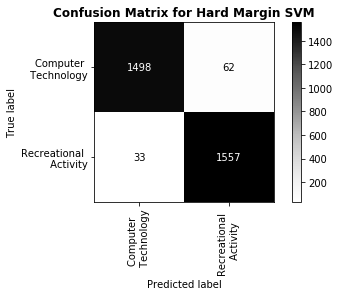

In [17]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Computer \n Technology', 'Recreational \n Activity']

plot_confusion_matrix(svm_hard, X_test_LSI, Y_test_SVM, display_labels=class_names, 
                             values_format='d', xticks_rotation=90, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Hard Margin SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_hard.png')

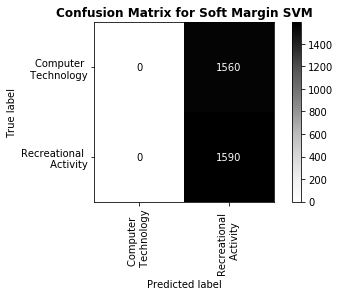

In [18]:
plot_confusion_matrix(svm_soft, X_test_LSI, Y_test_SVM, display_labels=class_names, 
                             values_format='d', xticks_rotation=90, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Soft Margin SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_soft.png')

In [19]:
from sklearn.model_selection import cross_val_score
# from sklearn import metrics
    
gammas = [1e-3, 3.3e-3, 1e-2, 3.3e-2, 1e-1, 3.3e-1, 1, 3.3, 1e1, 3.3e1, 1e2, 3.3e2, 1e3]
best_score = 0
for gamma in gammas:
    clf = SVC(kernel='linear', C=gamma)
    scores = cross_val_score(clf, X_train_LSI, Y_train_SVM, cv=5, scoring='accuracy')
    print('gamma = ', gamma, '; validation accuracy = ', scores)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_gamma = gamma

gamma =  0.001 ; validation accuracy =  [0.50475185 0.50475185 0.50528541 0.50528541 0.50422833]
gamma =  0.0033 ; validation accuracy =  [0.50475185 0.50475185 0.50528541 0.50528541 0.50422833]
gamma =  0.01 ; validation accuracy =  [0.50686378 0.50580781 0.50528541 0.50634249 0.50422833]
gamma =  0.033 ; validation accuracy =  [0.9218585  0.94403379 0.93446089 0.94397463 0.93868922]
gamma =  0.1 ; validation accuracy =  [0.95564942 0.97360084 0.96194503 0.96511628 0.96934461]
gamma =  0.33 ; validation accuracy =  [0.96832101 0.97782471 0.96934461 0.96300211 0.97885835]
gamma =  1 ; validation accuracy =  [0.97254488 0.97993664 0.97145877 0.96194503 0.97885835]
gamma =  3.3 ; validation accuracy =  [0.97465681 0.98099261 0.97357294 0.96511628 0.97885835]
gamma =  10.0 ; validation accuracy =  [0.97254488 0.98099261 0.97463002 0.96934461 0.98097252]
gamma =  33.0 ; validation accuracy =  [0.97571278 0.98310454 0.97357294 0.96934461 0.97780127]
gamma =  100.0 ; validation accuracy =  [

In [20]:
print('best gamma = ', best_gamma)
print('mean validation accuray = ', best_score)

best gamma =  33.0
mean validation accuray =  0.9759072267826964


In [21]:
svm_best = SVC(C=best_gamma, kernel='linear', random_state=42)
svm_best.fit(X_train_LSI, Y_train_SVM)

Y_test_label_best = svm_best.predict(X_test_LSI)
Y_test_prob_best = svm_best.decision_function(X_test_LSI)

print('Best Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_SVM, Y_test_label_best))
print('accuracy:', accuracy_score(Y_test_SVM, Y_test_label_best))
print('recall:', recall_score(Y_test_SVM, Y_test_label_best))
print('precision:', precision_score(Y_test_SVM, Y_test_label_best))
print('f1_score:', f1_score(Y_test_SVM, Y_test_label_best))

Best Linear SVMs:
confusion_matrix:
 [[1501   59]
 [  32 1558]]
accuracy: 0.9711111111111111
recall: 0.979874213836478
precision: 0.9635126777983921
f1_score: 0.9716245712503897


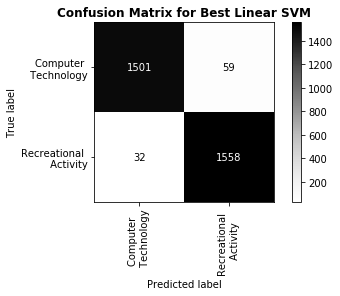

In [22]:
plot_confusion_matrix(svm_best, X_test_LSI, Y_test_SVM, display_labels=class_names, 
                             values_format='d', xticks_rotation=90, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Best Linear SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_best.png')

AUC of best value of the parameter gamma 0.9954483147879375


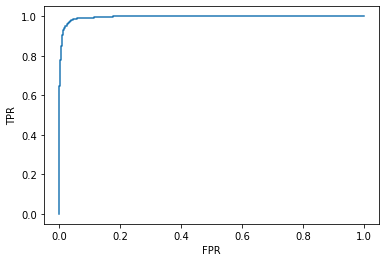

In [23]:
svm_best = SVC(C=best_gamma, kernel='linear', random_state=42)

svm_best.fit(X_train_LSI, Y_train_SVM)

Y_test_prob_best = svm_best.decision_function(X_test_LSI)
Y_test_label_best = svm_best.predict(X_test_LSI)

fpr_best, tpr_best, _ = roc_curve(Y_test_SVM, Y_test_prob_best)

plt.plot(fpr_best,tpr_best)

plt.xlabel('FPR')
plt.ylabel('TPR')
from sklearn.metrics import auc
auc_best = auc(fpr_best,tpr_best)
print('AUC of best value of the parameter gamma', auc_best)

## Question 7)

In [30]:
# from sklearn.pipeline import Pipeline
# step = [('vectorize', CountVectorizer(stop_word='English')), 
#         ('tfidf', TfidfTransformer()), 
#         ('reduce_dim', TruncatedSVD()),
#        ('clf', SVC())]
# pipeline = Pipeline(step)
from sklearn.pipeline import Pipeline
from pandas import 
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

pipeline = Pipeline([
    ('vectorize', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', SVC()),
])

parameters = [
    {
        'vectorize__min_df': [3,5],
        'reduce_dim': [TruncatedSVD(n_components=50, random_state=42), NMF(n_components=50, random_state=42)],
        'clf': [SVC(C=best_gamma, kernel='linear', random_state=42), GaussianNB(),
               LogisticRegression(C=logistic_l1_best.C, penalty = 'l1', solver='liblinear', random_state=42),
               LogisticRegression(C=logistic_l2_best.C, penalty = 'l2', solver='newton-cg', random_state=42)]
    }
]

NameError: name 'logistic_l1_best' is not defined